# Dataset 

In [1]:
use_trained = True

In [2]:
import sys
sys.path.append('../../datasets/')
from prepare_sequences import prepare, germanBats
import matplotlib.pyplot as plt
import pickle
import numpy as np

classes = germanBats

In [3]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = patch_len / 2                   # = 150ms ~ 15ms

resize = None

mode = 'slide'
options = {
    'seq_len': 60,                            # = 500ms with ~ 5 calls
    'seq_skip': 15,
}

X_test, Y_test = prepare("../../datasets/prepared.h5", classes, patch_len, patch_skip,
                                                         options, mode, resize, only_test=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:39<00:00,  2.21s/it]


In [4]:
print("Total sequences:", len(X_test))
print(X_test.shape, Y_test.shape)

Total sequences: 4979
(4979, 60, 44, 257) (4979,)


# Model

In [5]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn

batch_size = 64
num_classes = len(list(classes))

test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
test_loader = DataLoader(test_data, batch_size=batch_size)

In [6]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=(5, 7), stride=(2, 3), padding=3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

    nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=5, stride=2, padding=1),

    nn.Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 2), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
    nn.Flatten(1, -1),
    nn.Linear(64, len(list(classes)))
)
if use_trained:
    model.load_state_dict(torch.load('baseline_mixed.pth'))
else:
    model.load_state_dict(torch.load('baseline_small.pth'))
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)
print(device)

cuda:0


In [7]:
call_nocall_model = torch.jit.load('../call_nocall/call_nocall.pt')
call_nocall_model.to(device)
print(device)

cuda:0


In [8]:
import tqdm

corrects = 0.0

model.eval()

classes["unknown"] = 18

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    inputs, labels = inputs.to(device).unsqueeze(2), labels.to(device)
    
    for s in range(len(inputs)):
        cnc_outputs = call_nocall_model(inputs[s])
        cnc_pred = torch.argmax(cnc_outputs, 1) # call indices

        n_inputs = inputs[s, cnc_pred.nonzero().squeeze()]
        if n_inputs.shape[0] > 1:
            output = model(n_inputs)
            pred = torch.max(output, 1)[1]
            pred = torch.mode(pred)[0].item()
            corrects += (pred == labels[s]).sum()
        else:
            pass

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [01:20<00:00,  1.03s/it]


In [9]:
print("Accuracy:", corrects / len(test_data))

Accuracy: tensor(0.7305, device='cuda:0')


In [10]:
import random

def one_hot(x, num_classes, on_value=1., off_value=0., device='cuda'):
    x = x.long().view(-1, 1)
    return torch.full((x.size()[0], num_classes), off_value, device=device).scatter_(1, x, on_value)

def rand_y(Y, exclude_class):
    while True:
        idx = random.randint(0, len(Y)-1)
        if torch.logical_and(Y[idx], exclude_class).sum() == 0:
            return idx

def mixup(X, Y, num_classes, min_seq=2, max_seq=2):
    Y1 = one_hot(Y, num_classes, device=X.device)
    X2 = X.clone()
    Y2 = Y1.clone()
    for i, y in enumerate(Y):
        rand_k = random.randint(min_seq, max_seq)
        for k in range(3-rand_k):
            idx = rand_y(Y1, Y2[i])
            X2[i] += X[idx].squeeze()
            Y2[i] += Y1[idx].squeeze()
    return X2, Y2

def getCorrects(output, target):
    n_targets = target.sum(dim=1).int().cpu().detach().numpy()
    best_2 = torch.zeros_like(output)
    for i, e in enumerate(torch.argsort(output, 1)):
        best_2[i, e[-n_targets[i]:]] = 1
    log_and = torch.logical_and(best_2, target)
    corr = 0.0
    for i, t in enumerate(target):
        corr += log_and[i].sum() / t.sum()
    return corr

def getCorrect(output, target):
    n_targets = target.sum().int().cpu().detach().numpy()
    best_2 = torch.zeros_like(output)
    best_2[torch.argsort(output)[-n_targets:]] = 1
    return torch.logical_and(best_2, target).sum() / target.sum()

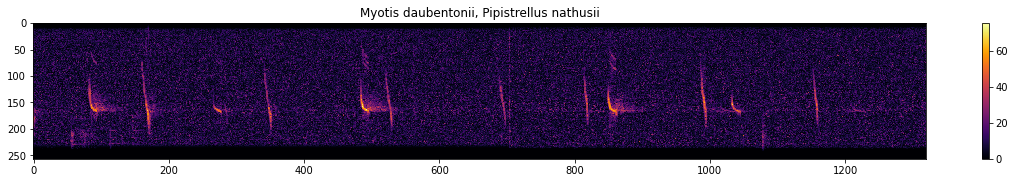

In [11]:
def stitch(a, r):
    return a[::r]
  
def plot_sequence(seq, y):
    plt.figure(figsize = (20, 2.5))
    stitched = stitch(seq, int(patch_len / patch_skip))
    spec = np.rot90(np.concatenate(stitched))
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])

k = random.randint(0, batch_size-1)
X1, Y1 = next(iter(test_loader))
X1, Y1 = mixup(X1, Y1, num_classes=num_classes, min_seq=1, max_seq=3)
plot_sequence(X1[k].detach().numpy(), Y1[k].detach().numpy())

In [12]:
from sklearn.metrics import hamming_loss, f1_score

mixed_corrects = 0.0
repeats = 5

predictions = []
targets = []

for r in range(repeats):
    # iterate over test data
    for inputs, labels in tqdm.tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)
        inputs = inputs.unsqueeze(2)

        for s in range(len(inputs)): # for each sequence in batch
            cnc_outputs = call_nocall_model(inputs[s])
            cnc_pred = torch.argmax(cnc_outputs, 1) # call indices

            n_inputs = inputs[s, cnc_pred.nonzero().squeeze()]
            if n_inputs.shape[0] > 1:
                output = model(n_inputs)
                mixed_corrects += getCorrect(output.mean(dim=0), labels[s])
                predictions.append(output.mean(dim=0).data.cpu().numpy())
            else:
                predictions.append(torch.zeros_like(labels[s]).data.cpu().numpy())
                
            targets.append(labels[s].data.cpu().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [01:21<00:00,  1.04s/it]


In [13]:
from sklearn.metrics import hamming_loss, f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print("Mixed test acc:", mixed_corrects / (repeats * len(test_data)))
print("Mixed hamming score:", hamming_loss(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets)))
print("Mixed f1 micro:", f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='micro'))
print("Mixed f1 macro:", f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='macro'))
print("Mixed f1 samples:", f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='samples'))

Mixed test acc: tensor(0.6680, device='cuda:0')
Mixed hamming score: 0.06935350695141818
Mixed f1 micro: 0.6388966350622792
Mixed f1 macro: 0.500362484726943
Mixed f1 samples: 0.6141445180870768
